<a href="https://colab.research.google.com/github/noo-rashbass/synthetic-data-service/blob/Aisha/Aisha/Evaluations/DWPre_PROGRESS_Lulu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Data Loading

In [2]:
def load_DoppelGANger(expand=False):
  ori_features = np.load('ori_features_prism.npy') # np.shape = (1347 participants, 130 visits, 5 features)
  ori_attributes = np.load('ori_attributes_prism.npy') # np.shape = (1347 participants, 330 one-hot attributes)

  gen_features = np.load('features_600.npy') # np.shape = (1347 participants, 130 visits, 5 features)
  gen_attributes = np.load('attributes_600.npy') # np.shape = (1347 participants, 330 one-hot attributes)

  if expand:
    ori_features, ori_attributes = expand_data(ori_features, ori_attributes)
    gen_features, gen_attributes = expand_data(gen_features, gen_attributes)

  return ori_features, ori_attributes, gen_features, gen_attributes

def expand_data(features, attributes):
  attributes = np.repeat(attributes, repeats=np.shape(features)[1], axis=0) # shape = (130*1347, 330)
  features = np.concatenate(tuple(features)) # shape = (130*1347, 5)
  # data = np.hstack((features, attributes)) # shape = (130*1347, 330+5)
  return features, attributes

# K-Nearest Neighbours Classification of attributes

Lulu: Using each one-hot encoded vector as a target category (I think). Maybe I should transform to integer categories.

In [4]:
ori_features, ori_attributes, gen_features, gen_attributes = load_DoppelGANger(expand=True)
ori_features_train, ori_features_test, ori_attributes_train, ori_attributes_test = train_test_split(ori_features, ori_attributes, test_size=0.2, random_state=0)
gen_features_train, gen_features_test, gen_attributes_train, gen_attributes_test = train_test_split(gen_features, gen_attributes, test_size=0.2, random_state=0)

### TRTR

In [4]:
ori_classifier = KNeighborsClassifier()
ori_classifier.fit(ori_features_train, ori_attributes_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [5]:
ori_classifier.score(ori_features_test, ori_attributes_test)

0.021557877905316658

### TSTS

In [6]:
gen_classifier = KNeighborsClassifier()
gen_classifier.fit(gen_features_train, gen_attributes_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [7]:
gen_classifier.score(gen_features_test, gen_attributes_test)

0.05896293758209126

# K-Nearest Neighbours Regression of Features

Lulu:
* not currently using any attributes
* using default uniform weights
* fixed TRTR params and used the same for TSTS (maybe I should try other way?)

### Define Evaluation Scheme

In [6]:
def make_x_y(features, y_index):
  x = np.delete(features, obj=y_index, axis=1)
  y = features[:, y_index]
  # print(np.shape(x))
  # print(np.shape(y))
  return x, y


def KNNR_train_test(features, y_index, radius, test_size=0.2):
  """ Experiments with K-Nearst Neighbors Regression on a single featureset

  Args:
  - features: 2D numpy array of non-categorical numerical data
  - y_index: list of y_index values
  - radius: list of KNNR radius parameters

  Returns
  - results: dataframe showing experiment parameters and scores

  """
  if not len(y_index)==len(radius):
    print('length of y_index and radius must be the same')
    return

  score = []
  for r in range(len(y_index)):
    print('Current column = ', y_index[r], ' radius = ', str(radius[r]))
    print('Making labels')
    x, y = make_x_y(features, y_index[r])
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size)
    print('Fitting model')
    regressor = KNeighborsRegressor(radius=radius[r])
    regressor.fit(train_x, train_y)

    print('Collecting results')
    score.append(regressor.score(test_x, test_y))

  
  results = pd.DataFrame(list(zip(y_index, radius, score)), columns=['column_index', 'radius', 'score'])

  return results


### TRTR

Experimenting before collecting TRTR results

In [7]:
y_index=[0]*3
radius=[1,2,3]

ori_results = KNNR_train_test(ori_features, y_index, radius)

Current column =  0  radius =  1
Making labels
Fitting model
Current column =  0  radius =  2
Making labels
Fitting model
Current column =  0  radius =  3
Making labels
Fitting model


In [10]:
ori_results2 = KNNR_train_test(ori_features, y_index=[1,2,3,4], radius=[1,1,1,1])

Current column =  1  radius =  1
Making labels
Fitting model
Current column =  2  radius =  1
Making labels
Fitting model
Current column =  3  radius =  1
Making labels
Fitting model
Current column =  4  radius =  1
Making labels
Fitting model


In [12]:
ori_results1 = KNNR_train_test(ori_features, y_index=[0], radius=[1])

Current column =  0  radius =  1
Making labels
Fitting model


In [15]:
ori_results3 = KNNR_train_test(ori_features, y_index=[0], radius=[5])

Current column =  0  radius =  5
Making labels
Fitting model


In [17]:
ori_results4 = KNNR_train_test(ori_features, y_index=[0]*2, radius=[0.75, 0.25])

Current column =  0  radius =  0.75
Making labels
Fitting model
Current column =  0  radius =  0.25
Making labels
Fitting model


In [18]:
ori_results4

,column_index,radius,score
0,0,0.75,0.289725
1,0,0.25,0.295882


In [27]:
TRTR_results = pd.concat([ori_results1, ori_results2])
TRTR_results.to_csv('dp_dwpre_knnr_trtr_results.csv')

### TSTS

Collecting TSTS results using the same parameters as the TRTR

In [20]:
gen_results = KNNR_train_test(gen_features, y_index=[0,1,2,3,4], radius=[1]*5)

Current column =  0  radius =  1
Making labels
Fitting model
Current column =  1  radius =  1
Making labels
Fitting model
Current column =  2  radius =  1
Making labels
Fitting model
Current column =  3  radius =  1
Making labels
Fitting model
Current column =  4  radius =  1
Making labels
Fitting model


In [23]:
TSTS_results = gen_results
TSTS_results.to_csv('dp_dwpre_knnr_tsts_results.csv')

### Comparison

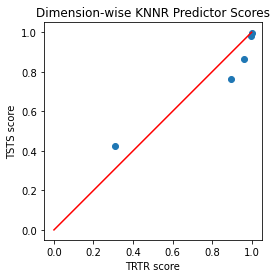

In [31]:
plt.plot([0,1], [0,1], color='r')
plt.scatter(TRTR_results['score'], TSTS_results['score'])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('TRTR score')
plt.ylabel('TSTS score')
plt.title('Dimension-wise KNNR Predictor Scores')
plt.axis('square')
plt.show()